In [0]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from sklearn import metrics
import warnings
import xgboost
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import learning_curve
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("/content/gdrive/My Drive/RandomForest")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
train_dataset = pd.read_csv('training_data_1_12.csv', names=["vx", "vy", "vz", "dx", "dy", "vfx", "vfy", "vfz", "afx", "afy", "afz", "num_v_labels", "ax", "ay", "az"])
test_dataset = pd.read_csv('validation_data_1_12.csv', names=["vx", "vy", "vz", "dx", "dy", "vfx", "vfy", "vfz", "afx", "afy", "afz", "num_v_labels", "ax", "ay", "az"])
train_dataset = train_dataset.drop(train_dataset.index[0])
test_dataset = test_dataset.drop(test_dataset.index[0])

In [0]:
X_train = train_dataset.iloc[:, :12]
X_test = test_dataset.iloc[:, :12]
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

In [0]:
Y_train_ax, Y_train_ay, Y_train_az = train_dataset.iloc[:,12], train_dataset.iloc[:,13], train_dataset.iloc[:, 14]
Y_test_ax, Y_test_ay, Y_test_az = test_dataset.iloc[:, 12], test_dataset.iloc[:, 13], test_dataset.iloc[:, 14]
Y_train_ax, Y_train_ay, Y_train_az = Y_train_ax.astype(np.float), Y_train_ay.astype(np.float), Y_train_az.astype(np.float)
Y_test_ax, Y_test_ay, Y_test_az = Y_test_ax.astype(np.float), Y_test_ay.astype(np.float), Y_test_az.astype(np.float)

In [0]:
from sklearn.model_selection import GridSearchCV
import pickle

def train_model(clf, X_train, y_train, X_test, y_test):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        train_sizes = [1, 100, 1000, 10000, 14122]
        train_sizes, train_scores, validation_scores = learning_curve(estimator=clf, X=X_train, y=Y_train_ax, 
                                                                      train_sizes=train_sizes, cv=5, scoring='neg_mean_absolute_error')
        
        train_scores_mean = -train_scores.mean(axis = 1)
        validation_scores_mean = -validation_scores.mean(axis = 1)
        clf.fit(X_train, y_train)
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print("")
        y_true, y_pred = y_test, clf.predict(X_test)
        print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
        print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
        print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
        
        return train_scores_mean, validation_scores_mean

In [11]:
random_forest_regressor = RandomForestRegressor(max_depth=80, max_features=3, n_estimators=500)
adaboost_regressor = AdaBoostRegressor(learning_rate=0.1, loss='exponential', n_estimators=50)
extra_trees_regressor = ExtraTreesRegressor(max_features=10, n_estimators=500)
gradient_boosting_regressor = GradientBoostingRegressor(learning_rate=0.02, max_depth=6, max_features=1.0, n_estimators=100)

estimators = [
  ('rfr', random_forest_regressor),
  ('abr', adaboost_regressor),
  ('etr', extra_trees_regressor),
  ('gbr', gradient_boosting_regressor)
]

model = VotingRegressor(estimators)
train_scores_mean_ax, validation_scores_mean_ax = train_model(model, X_train, Y_train_ax, X_test, Y_test_ax)
train_scores_mean_ay, validation_scores_mean_ay = train_model(model, X_train, Y_train_ay, X_test, Y_test_ay)
train_scores_mean_az, validation_scores_mean_az = train_model(model, X_train, Y_train_az, X_test, Y_test_az)

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Mean Absolute Error: 0.3062644349698517
Mean Squared Error: 0.2445410486332857
Root Mean Squared Error: 0.49451091861887714
The model is trained on the full development set.
The scores are computed on the full evaluation set.

Mean Absolute Error: 0.2455961242384071
Mean Squared Error: 0.1593026628602838
Root Mean Squared Error: 0.399127376736154
The model is trained on the full development set.
The scores are computed on the full evaluation set.

Mean Absolute Error: 0.10306331556868915
Mean Squared Error: 0.03344153112640741
Root Mean Squared Error: 0.18287025763203651


In [0]:
train_scores_mean = (train_scores_mean_ax + train_scores_mean_ay + train_scores_mean_az) / 3.0
validation_scores_mean = (validation_scores_mean_ax + validation_scores_mean_ay + validation_scores_mean_az) / 3.0

Mean training scores

 1        6.938894e-19
100      1.949251e-02
1000     7.123584e-02
10000    9.322623e-02
14122    9.574112e-02
dtype: float64

 --------------------

Mean validation scores

 1        0.267035
100      0.516995
1000     0.275628
10000    0.226588
14122    0.215189
dtype: float64


(0, 0.6)

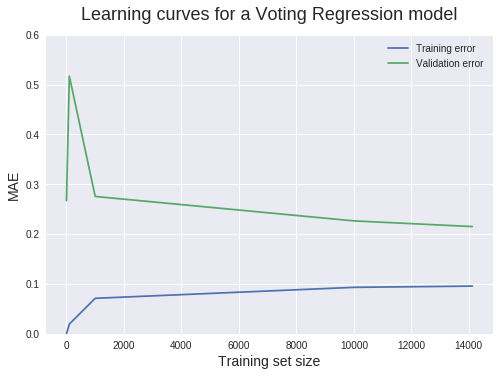

In [21]:
train_sizes = [1, 100, 1000, 10000, 14122]
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MAE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a Voting Regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,0.6)